In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os.path

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dfToDict, dictToDF
from incidenceToProjection import makeHiC_fromInc

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'


In [2]:
## Read in example file
projMat = None
numFiles = 10000
for i in range(1,numFiles):
    filePath = f'{dataDir}chains_10k_500_projectionMtxOutput/projMat_{i}.txt'
    if os.path.isfile(filePath):
        if projMat is None:
            projMat = np.loadtxt(filePath) / numFiles
        else:
            projMat += (np.loadtxt(filePath) / numFiles)

nrow = projMat.shape[0]

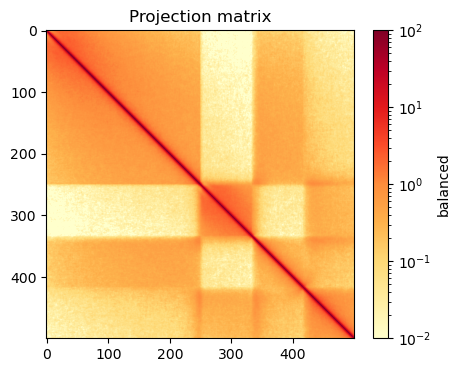

In [6]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm(vmax=10**2, vmin = 0.01))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Projection matrix")
plt.show()

In [14]:
## read in summary file
summaryFile = f'{dataDir}chains_10k_500_projectionMtxOutput/summary.txt'
summary = pd.read_table(summaryFile,names=["runID","numReads","maxCard"])
summary.head()


,runID,numReads,maxCard
0,98,29049,7.0
1,64,25193,7.0
2,45,30039,7.0
3,61,32252,7.0
4,19,29120,7.0


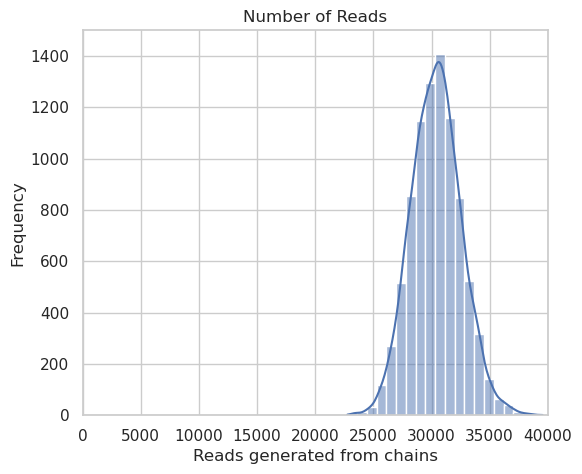

In [25]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot a histogram using seaborn
plt.figure(figsize=(6, 5))  # Set the figure size
sns.histplot(data=summary, x="numReads", bins=20, kde=True)  

# Set x and y limits
plt.xlim(0, 4*10**4) 
plt.ylim(0, 1500) 

# Add labels and title
plt.xlabel("Reads generated from chains")
plt.ylabel("Frequency")
plt.title("Number of Reads")

# Show the plot
plt.show()

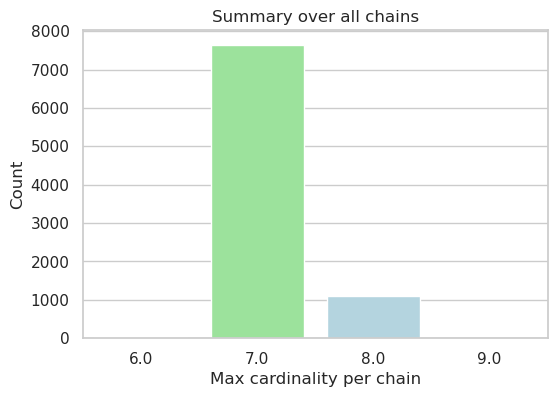

In [33]:
# Plot a bar plot using seaborn
plt.figure(figsize=(6, 4))  # Set the figure size

# Define custom colors
custom_colors = ["lightblue","lightgreen"]
sns.countplot(data=summary, x="maxCard",palette = custom_colors)

# Add labels and title
plt.xlabel("Max cardinality per chain")
plt.ylabel("Count")
plt.title("Summary over all chains")

# Show the plot
plt.show()

In [36]:
ix = 3
filePath = f'{dataDir}chains_10k_500_projectionMtxOutput/incDF_{ix}.pkl'
incDF = pd.read_pickle(filePath)
filePath = f'{dataDir}chains_10k_500_projectionMtxOutput/binConcatInc_{ix}.pkl'
bIncDF = pd.read_pickle(filePath)

print(incDF.shape)
print(bIncDF.shape)

(500, 31095)
(100, 26621)


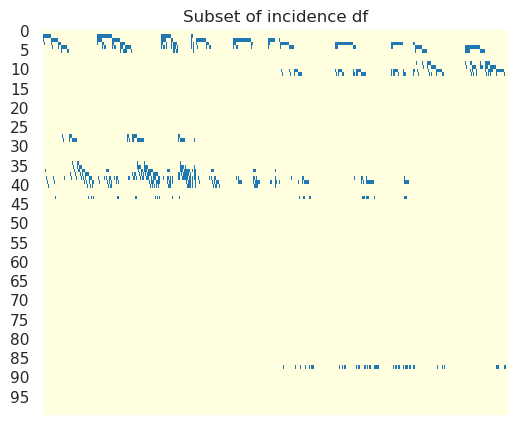

In [43]:
# Define custom colors for the heatmap
colors = ["#FFFFE0", "#1F77B4"]

subset_df = incDF.iloc[:100,:500]

plt.figure(figsize=(6, 5))  # Set the figure size
sns.heatmap(data=subset_df, cmap=colors, cbar=False,xticklabels=False)  # Use the custom colors and remove color bar

# Add title
plt.title("Subset of incidence df")

# Show the plot
plt.show()

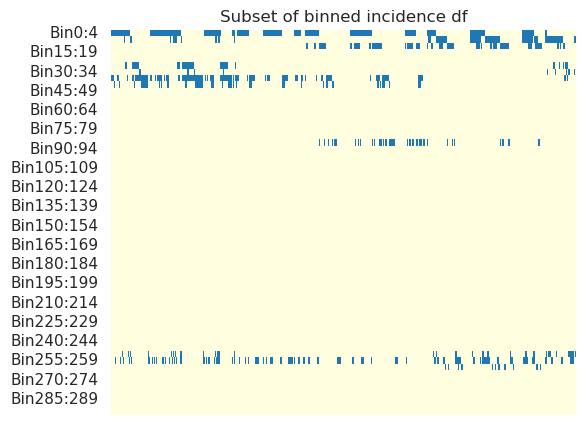

In [45]:
# Define custom colors for the heatmap
colors = ["#FFFFE0", "#1F77B4"]

subset_df = bIncDF.iloc[:60,:500]

plt.figure(figsize=(6, 5))  # Set the figure size
sns.heatmap(data=subset_df, cmap=colors, cbar=False,xticklabels=False)  # Use the custom colors and remove color bar

# Add title
plt.title("Subset of binned incidence df")

# Show the plot
plt.show()

In [97]:
def constructFullDict(listOfDFs):
    """Takes in a list of DFs and outputs a dict"""
    result_dict = {}
    numEdges = []
    for df in listOfDFs:
        result_dict = dfToDict(df,result_dict)
        nE = len(result_dict)
        numEdges.append(nE)
    return(result_dict,numEdges)

In [98]:
## Was playing around with 50. Ran a job for 1000
numFiles = 50

fileList = []
for ix in range(1,numFiles+1):
    filePath = f'{dataDir}chains_10k_500_projectionMtxOutput/binConcatInc_{ix}.pkl'
    if os.path.isfile(filePath):
        bIncDF = pd.read_pickle(filePath)
        fileList.append(bIncDF)

hpEdges, numEdges = constructFullDict(fileList)

In [3]:
import pickle
numFiles = 10000
with open(f'{dataDir}hyperEdges_{numFiles}_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

numEdges = np.loadtxt(f'{dataDir}numEdges_{numFiles}_chains.txt')

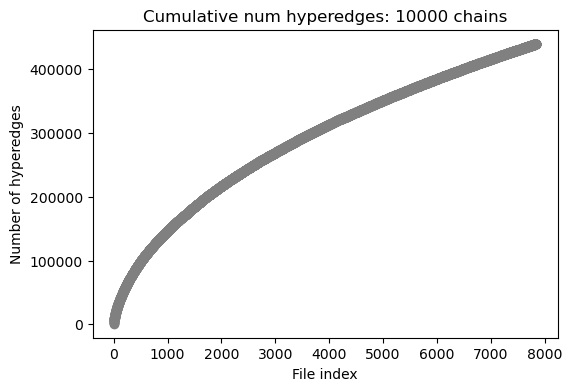

In [4]:
plt.figure(figsize=(6, 4))

indices = list(range(1,len(numEdges)+1))

# Create a dot plot with connecting lines
plt.plot(indices, numEdges, marker='o', linestyle='-', color='grey')

# Add labels and title
plt.xlabel("File index")
plt.ylabel("Number of hyperedges")
plt.title(f"Cumulative num hyperedges: {numFiles} chains")

# Show the plot
plt.show()

In [5]:
card = [len(k.split("_")) for k in hpEdges.keys()]
edgeSupport = [v for v in hpEdges.values()]

edgeSupp_byCard = pd.DataFrame({'Cardinality':card, 'ReadSupportPerHPE': edgeSupport})
edgeSupp_byCard.head()

,Cardinality,ReadSupportPerHPE
0,2,232447
1,2,11792
2,2,3230
3,2,17598
4,2,13610


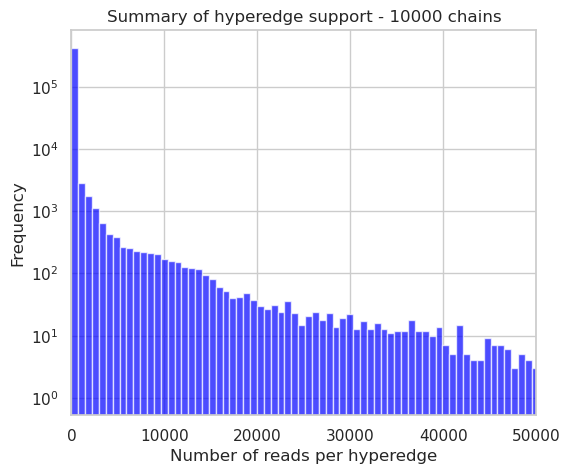

In [9]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot a histogram using seaborn
plt.figure(figsize=(6, 5))  # Set the figure size
plt.hist(edgeSupport, bins = 500, color='blue', alpha=0.7)

# Set x and y limits
plt.yscale("log")
plt.xlim(0, 50000) 

# Add labels and title
plt.xlabel("Number of reads per hyperedge")
plt.ylabel("Frequency")
plt.title(f"Summary of hyperedge support - {numFiles} chains")

# Show the plot
plt.show()

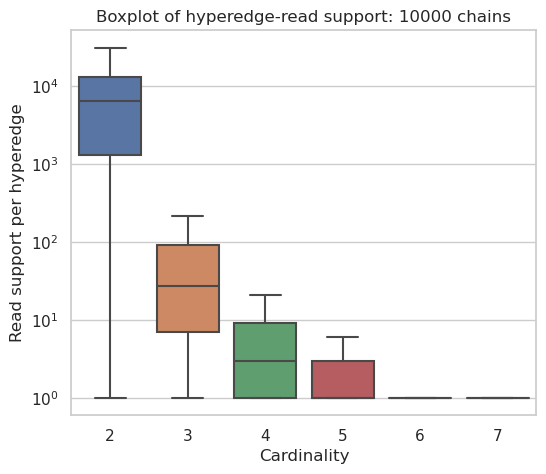

In [10]:
# Create a boxplot using seaborn
plt.figure(figsize=(6, 5))
sns.boxplot(data=edgeSupp_byCard, x='Cardinality', y='ReadSupportPerHPE',showfliers=False)

#plt.xlim(0, 50)
plt.yscale("log")

# Add labels and title
plt.xlabel("Cardinality")
plt.ylabel("Read support per hyperedge")
plt.title(f"Boxplot of hyperedge-read support: {numFiles} chains")

# Show the plot
plt.show()

## Evaluate best distance cutoff 

In [2]:
sf = f'{dataDir}eval_optimalDistCutoff/summary.txt'
summaryFile = pd.DataFrame(np.loadtxt(sf),columns=['ID','numReads','maxCard','dist_prim','dist_sec','offDiagDist'])
summaryFile.head()

,ID,numReads,maxCard,dist_prim,dist_sec,offDiagDist
0,1.0,2864.0,4.0,500.0,500.0,2.0
1,2.0,4075.0,6.0,500.0,550.0,2.0
2,4.0,7934.0,7.0,500.0,650.0,2.0
3,3.0,6004.0,6.0,500.0,600.0,2.0
4,5.0,15099.0,9.0,500.0,750.0,2.0


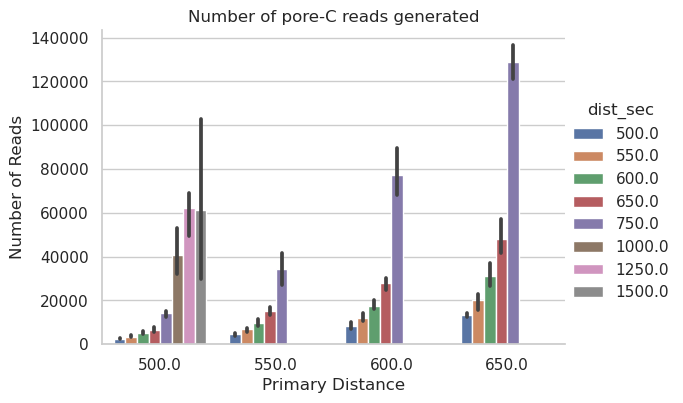

In [11]:
# Create faceted bar plots using seaborn
sns.set(style="whitegrid")  # Set the plot style

# Create the bar plot
g = sns.catplot(
    data=summaryFile,
    x="dist_prim",
    hue="dist_sec",
    y="numReads",
    kind="bar",
    height=4,
    aspect=1.5,
)

# Customize the plot
g.set_axis_labels("Primary Distance", "Number of Reads")
g.set(title="Number of pore-C reads generated")

# Show the plot
plt.show()


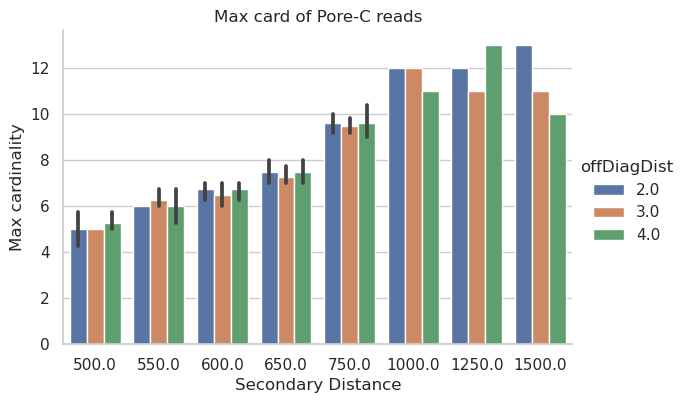

In [14]:
# Create faceted bar plots using seaborn
sns.set(style="whitegrid")  # Set the plot style

# Create the bar plot
g = sns.catplot(
    data=summaryFile,
    x="dist_sec",
    hue="offDiagDist",
    y="maxCard",
    kind="bar",
    height=4,
    aspect=1.5,
)

# Customize the plot
g.set_axis_labels("Secondary Distance", "Max cardinality")
g.set(title="Max card of Pore-C reads")

# Show the plot
plt.show()

In [3]:
allFiles = os.listdir(f'{dataDir}eval_optimalDistCutoff/')
fileList = {}
cardDict = {}
projMats = {}
for file in allFiles:
    if 'incDF_3_' in file and '750' in file:
        bIncDF = pd.read_pickle(f'{dataDir}eval_optimalDistCutoff/{file}')
        fileList[file] = bIncDF
        card = bIncDF.sum()
        cardDict[file] = card
        hic_mat = makeHiC_fromInc(bIncDF)
        projMats[file] = hic_mat


In [12]:
del cardDict['incDF_3_600_750_111.pkl']
del cardDict['incDF_3_550_750_107.pkl']
cardDict.keys()

del projMats['incDF_3_600_750_111.pkl']
del projMats['incDF_3_550_750_107.pkl']

In [9]:
card.max()

9.0

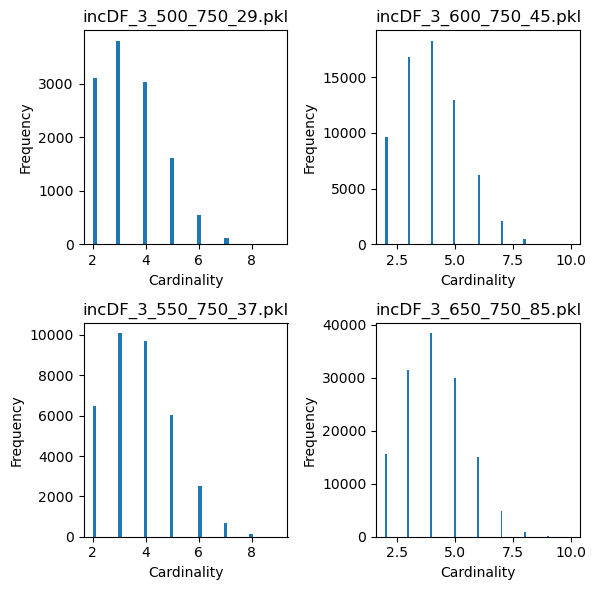

In [10]:
# Get the number of elements in the dictionary
num_plots = len(cardDict)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_plots + 1) // 2  # Ceiling division to ensure enough columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

# Flatten the axes array if necessary
axes = axes.flatten()

# Iterate through dictionary items and create histograms in subplots
for i, (filename, data) in enumerate(cardDict.items()):
    axes[i].hist(data,bins = "auto")
    axes[i].set_xlabel('Cardinality')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{filename}')
    
# Adjust layout
plt.tight_layout()

# Display the subplots
plt.show()

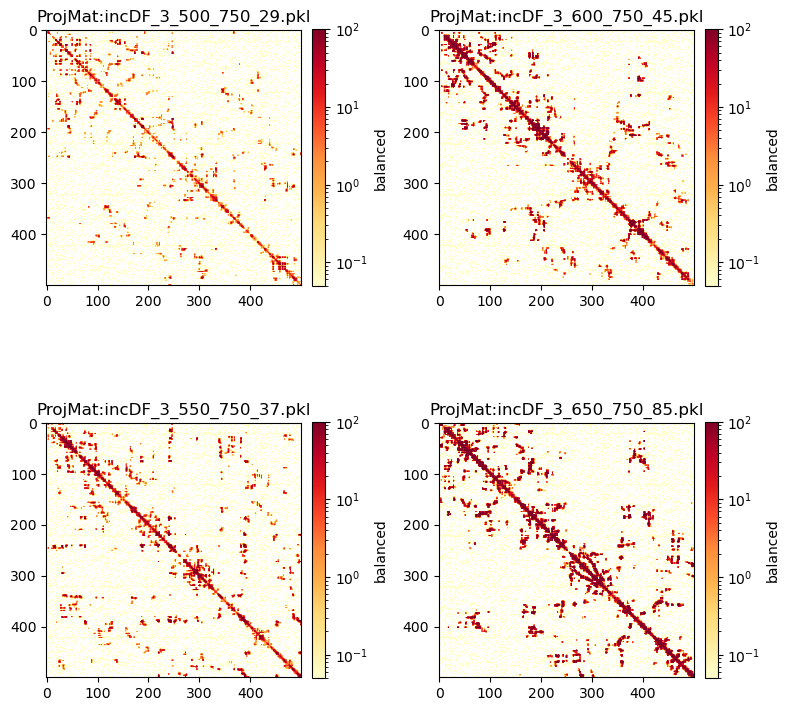

In [13]:
from matplotlib.colors import LogNorm

# Get the number of elements in the dictionary
num_plots = len(projMats)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_plots + 1) // 2  # Ceiling division to ensure enough columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

# Flatten the axes array if necessary
axes = axes.flatten()

# Iterate through dictionary items and create images in subplots
for i, (filename, data) in enumerate(projMats.items()):
    ax = axes[i]
    im = ax.imshow(data, cmap="YlOrRd", norm=LogNorm(vmax=100, vmin=0.05))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='balanced')
    ax.set_title(f"ProjMat:{filename}")

# Adjust layout
plt.tight_layout()

# Display the subplots
plt.show()


In [133]:
pruned_edges = {key: value for key, value in hpEdges.items() if value >= 3}
rep_HD_edge = {key: value for key, value in hpEdges.items() if value >= 5 and len(key.split("_")) == 6}

In [171]:
rep_HD_edge
list(rep_HD_edge.keys())[0].split("_")

['Bin90:94',
 'Bin185:189',
 'Bin190:194',
 'Bin205:209',
 'Bin375:379',
 'Bin390:394']

In [163]:
{key:value for key, value in pruned_edges.items() if key in rep_HD_edge}

{'Bin90:94_Bin185:189_Bin190:194_Bin205:209_Bin375:379_Bin390:394': 5}

In [172]:
A = [k for k in hpEdges.keys()]
A[0:4]

['Bin0:4_Bin30:34',
 'Bin0:4_Bin115:119',
 'Bin0:4_Bin385:389',
 'Bin0:4_Bin390:394']

In [166]:
hpEdges['Bin90:94_Bin375:379']

24